# Stochastic Gradient Descent for Logistic Regression

Mini-batch stochastic gradient descent is nowadays widely used for large scale machine learning. In this notebook, we'll show how to code up mini-batch SGD algorithms with Python for learning binary logistic classifiers. 

##  Binary Logistic Regression

### Loss Function

Given a data sample $\mathbf{x}_i=(1, x_1,\dots,x_p)$ (saved as row vector) with $p$ features, the prediction is

$$
\hat{y}_i = P(Y=1|X= \mathbf{x}_i) =  \frac{1}{1+ e^{-\mathbf{x}_i^\top \boldsymbol \theta  }}
$$ 

The **cross-entropy/log loss** for the $i$-th sample is given by

\begin{align*}
l_i(\boldsymbol \theta ) = & - y_i \log \hat{y}_i - (1-y_i) \log (1 - \hat{y}_i)\\
= & 
\begin{cases}
- \log \frac{1}{1+ e^{-\mathbf{x}_i^\top \boldsymbol \theta  }}  &  \mbox{if } y_i = 1 \\
- \log  \frac{e^{-\mathbf{x}_i^\top \boldsymbol \theta }}{1+ e^{-\mathbf{x}_i^\top \boldsymbol \theta  }} &  \mbox{if } y_i =0
\end{cases}
\end{align*}

The training process requires to solve

$$
\boldsymbol \theta^* = \arg\min_{\boldsymbol \theta\in\mathbb{R}^{p+1}} \; L(\boldsymbol \theta ) := \frac{1}{n}\sum_{i=1}^n l_i(\boldsymbol \theta )
$$

### Gradient in Matrix Form
Denote the sigmoid function by $\sigma(z) := \frac{1}{1+e^{-z}}$, we have
$$
\sigma^\prime(z) = \sigma(z)(1-\sigma(z))
$$

Since $\hat{y}_i = \sigma(\mathbf{x}_i^\top \boldsymbol \theta)$,

$$
\nabla_{\boldsymbol\theta} \hat{y}_i =  \sigma^\prime (\mathbf{x}_i^\top \boldsymbol \theta) \, \mathbf{x}_i
= \hat{y}_i (1-\hat{y}_i) \, \mathbf{x}_i
$$

Therefore,

\begin{align*}
\nabla l_i(\boldsymbol \theta ) = & \, - \nabla \left(y_i \log \hat{y}_i + (1-y_i) \log (1 - \hat{y}_i)\right) \\
= & \, - \left( \frac{y_i}{\hat{y}_i} \nabla \hat{y}_i - \frac{1-y_i}{1-\hat{y}_i} \nabla \hat{y}_i \right) \\
= & \, - y_i (1-\hat{y}_i) \, \mathbf{x}_i + \hat{y}_i (1- y_i) \, \mathbf{x}_i\\
= & \, \mathbf{x}_i(\hat{y}_i - y_i) 
\end{align*}

and

$$
\nabla L(\boldsymbol \theta)  = \frac{1}{n}\sum_{i=1}^n \nabla l_i(\boldsymbol \theta ) = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i(\hat{y}_i - y_i) = \frac{1}{n} \mathbf{X}^\top (\mathbf{\hat{y}}- \mathbf{y})
= \frac{1}{n} \mathbf{X}^\top \left(\sigma(\mathbf{X}\boldsymbol\theta) - \mathbf{y}\right)
$$

where the $i$-th row of $\mathbf{X}\in\mathbb{R}^{n\times (p+1)}$ is $\mathbf{x}_i^\top$.

### Inference 
We predict Class 1 if $\mathbf{x}^\top \boldsymbol \theta^* > 0$, i.e., $\hat{y} > 0.5$, and Class 0 otherwise.

### Accuracy

$$
\frac{\# \mbox{ correctly classified samples}}{\# \mbox{ samples in total}}
$$

## Mini-Batch SGD
SGD is the workhorse for large-scale emprical risk minimization:

$$
\min_{\boldsymbol \theta\in\mathbb{R}^{p+1}} \; L(\boldsymbol \theta ):=\frac{1}{n}\sum_{i=1}^n l_i(\boldsymbol \theta )
$$

**(Standard) gradient descent**: with the learning rate $\eta>0$,

$$
\boldsymbol \theta \leftarrow \boldsymbol \theta - \eta \left(\frac{1}{n} \sum_{i=1}^n \nabla l_i(\boldsymbol \theta )\right)
$$
where $\sum_{i=1}^n \nabla l_i(\boldsymbol \theta ) = \nabla L(\boldsymbol \theta ) = \mathbf{X}^\top \left(\sigma(\mathbf{X}\boldsymbol\theta) - \mathbf{y}\right).$

* requires to evaluate the gradients of $n$ functions in each iteration
* computationally prohibitive when $n$ is exceedingly large, i.e, the amount of data is very large.

**Stochastic gradient descent**: Randomly group the training samples into batches of size $b \ll n$. In each iteration, choose one batch $\mathcal{I}$ **without replacement** and update $\boldsymbol \theta $ using the averaged gradients over the samples in the batch:

$$
\boldsymbol \theta \leftarrow \boldsymbol \theta - \eta \left(\frac{1}{b} \sum_{i\in \mathcal{I}} \nabla l_i(\boldsymbol \theta )\right),
$$

where 
$$
\sum_{i\in \mathcal{I}} \nabla l_i(\boldsymbol \theta ) = \mathbf{X}_{\mathcal{I}}^\top \left(\sigma(\mathbf{X}_{\mathcal{I}} \boldsymbol\theta) - \mathbf{y}_{\mathcal{I}}\right)
$$
is the **mini-batch gradient**.

* when one pass (known as **epoch**) of the entire training dataset has been completed, start the next epoch by reshuffling the data. 

* train for a number of epochs 

* ideally, take diminishing $\eta \downarrow 0$ as SGD proceeds

* $\frac{1}{b} \sum_{i\in \mathcal{I}} \nabla l_i(\boldsymbol \theta )$ is unbiased estimate of $\frac{1}{n} 
\sum_{i=1}^n \nabla l_i(\boldsymbol \theta )$

* \# iterations in one epoch $= \frac{n}{b}$, roughly

* implementation of SGD consists of two ``for`` loops

## Main Python Code

We define the class of ``LogisticClassifier`` and several object oriented methods like ``fit`` and ``predict``:

In [1]:
class LogisticClassifier(object):
    def __init__(self, lr=0.1, epochs=100, batch_size=100, normalize = False):
        # sgd parameters
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        
        self.normalize = normalize
        
        self.loss_history = []
        self.accuracy_history = []
    
        

    def _assemble_x(self, X):
        # nomarlize the data and concatenate ones 
        if self.normalize:
            means = X.mean(axis=0)
            std = np.std(X, axis=0)
            X = (X - means)/std        
        # add intercept column to the design matrix
        X = np.hstack([ np.ones((X.shape[0], 1)), X])
        return X
        
    def fit(self, X, y):
        n, p = X.shape # n = # samples, p = # features
        X = self._assemble_x(X)
    
        # initialize parameters
        self.theta = np.zeros(p + 1)
            
        for epoch in range(self.epochs):
            
            # shuffle the samples
            shuffle = np.random.permutation(n)
            X = X[shuffle, :]
            y = y[shuffle]
        
            # if batch_size does not evenly divide n, we'll need one more
            # batch of size less than batch_size at the end.
            r = (1 if n % self.batch_size else 0)
            
            for i in range(n // self.batch_size + r):
                batch_slice = slice(self.batch_size * i, self.batch_size * (i + 1) )
                X_batch = X[batch_slice, :]
                y_batch = y[batch_slice]
        
                y_batch_hat = sigmoid(X_batch @ self.theta)
                # update parameters
                gradient = X_batch.T @ (y_batch_hat - y_batch)/self.batch_size
                self.theta -= self.lr * gradient
                
            y_hat = sigmoid(X @ self.theta)
            loss = np.mean(-y * np.log(y_hat) - (1-y) * np.log(1-y_hat))
            self.loss_history.append(loss)
            y_preds = (y_hat > 0.5).astype(int)
            accuracy = self.accuracy(y_preds,y)
            self.accuracy_history.append(accuracy)
            if (epoch + 1)%5 == 0:
                print('Epoch', epoch, ': training loss=', "{:.5f}".format(loss), ', training accuracy=', accuracy, '%' )

            
        
    def predict(self, X):
        X = self._assemble_x(X)
        return (X @ self.theta > 0).astype(int)
    
    def accuracy(self, y_preds, y):
        return np.mean(y_preds == y)*100

## Advertising Data Set

We work with an advertising data set, predicting whether or not a particular internet user will click on an Advertisement on a company website based on the features of that user.

This data set contains the following features:

* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': cutomer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get the Data
**Read in the advertising.csv file and set it to a data frame called ad_data.**

In [2]:
ad_data = pd.read_csv('advertising.csv')

**Check the head of ad_data**

In [3]:
ad_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


**Use info and describe() on ad_data**

In [4]:
ad_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   str    
 5   City                      1000 non-null   str    
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   str    
 8   Timestamp                 1000 non-null   str    
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), str(4)
memory usage: 78.3 KB


In [5]:
ad_data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


## Exploratory Data Analysis

**Use seaborn to create a histogram of the Age**

Text(0.5, 0, 'Age')

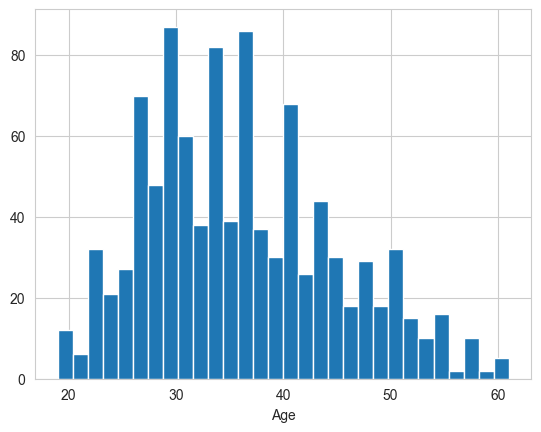

In [6]:
sns.set_style('whitegrid')
ad_data['Age'].hist(bins=30)
plt.xlabel('Age')

**Create a jointplot showing the kde distributions of Daily Time spent on site vs. Age.**

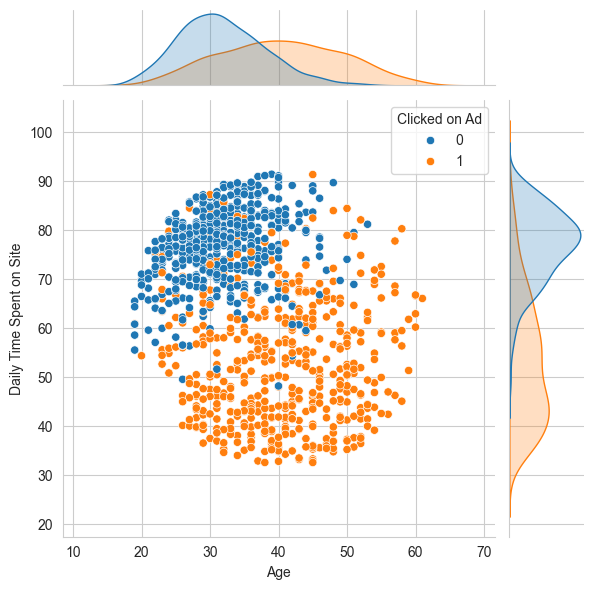

In [7]:
sns.jointplot(x='Age', y='Daily Time Spent on Site', data=ad_data, color='red', hue = 'Clicked on Ad');

**Create a jointplot of 'Daily Time Spent on Site' vs. 'Daily Internet Usage'**

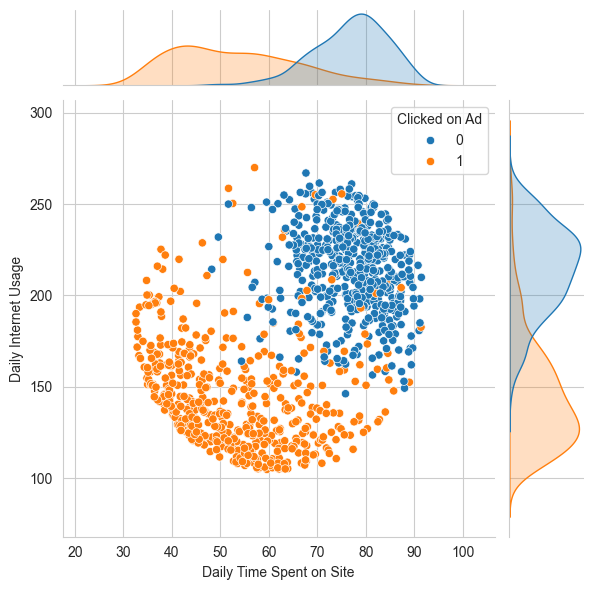

In [8]:
sns.jointplot(x ='Daily Time Spent on Site', y = 'Daily Internet Usage', data=ad_data, hue = 'Clicked on Ad')

## Train Logistic Regression Model

Do a train test split, and train our model. **Split the data into training set and testing set using train_test_split**

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = np.array(ad_data[['Daily Time Spent on Site', 'Age', 'Area Income','Daily Internet Usage', 'Male']])
y = np.array(ad_data['Clicked on Ad'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Build a class of ``LogisticClassifier``**

In [12]:
# sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
class LogisticClassifier(object):
    def __init__(self, lr=0.1, epochs=100, batch_size=100, normalize = False):
        # sgd parameters
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.normalize = normalize
        # self.lam = float(lam)
        self.loss_history = []
        self.accuracy_history = []
    
        

    def _assemble_x(self, X):
        # nomarlize the data and concatenate ones 
        if self.normalize:
            means = X.mean(axis=0)
            std = np.std(X, axis=0)
            X = (X - means)/std        
        # add intercept column to the design matrix
        X = np.hstack([ np.ones((X.shape[0], 1)), X])
        return X
        
    def fit(self, X, y):
        n, p = X.shape # n = # samples, p = # features 
        X = self._assemble_x(X)
    
        # initialize parameters
        self.theta = np.zeros(p + 1)
            
        for epoch in range(self.epochs):
            
            # shuffle the samples
            shuffle = np.random.permutation(n)
            X = X[shuffle, :]
            y = y[shuffle]
        
            # if batch_size does not evenly divide n, we'll one more
            # batch of size less than batch_size at the end.
            r = (1 if n % self.batch_size else 0)
            
            for i in range(n // self.batch_size + r):
                batch_slice = slice(self.batch_size * i, self.batch_size * (i + 1) )
                X_batch = X[batch_slice, :]
                y_batch = y[batch_slice]
        
                y_hat = sigmoid(X_batch @ self.theta)
                # update parameters
                gradient = X_batch.T @ (y_hat - y_batch)/self.batch_size 
                self.theta -= self.lr * gradient
                
            y_hat = sigmoid(X @ self.theta)
            loss = np.mean(-y * np.log(y_hat) - (1-y) * np.log(1-y_hat)) 
            self.loss_history.append(loss)
            y_preds = (y_hat > 0.5).astype(int)
            accuracy = self.accuracy(y_preds,y)
            self.accuracy_history.append(accuracy)
            if (epoch + 1)%5 == 0:
                print('Epoch', epoch, ': training loss=', "{:.5f}".format(loss), ', training accuracy=', accuracy, '%' )

            
        
    def predict(self, X):
        X = self._assemble_x(X)
        return (X @ self.theta > 0).astype(int)
    
    def accuracy(self, y_preds, y):
        return np.mean(y_preds == y)*100

**Train the model by setting learning rate, batch_size and the number of epochs**

In [14]:
model = LogisticClassifier(lr = .05, batch_size = 10, epochs = 100, normalize =True)
%time model.fit(X_train, y_train)

Epoch 4 : training loss= 0.11249 , training accuracy= 97.375 %
Epoch 9 : training loss= 0.09527 , training accuracy= 97.875 %
Epoch 14 : training loss= 0.08862 , training accuracy= 97.75 %
Epoch 19 : training loss= 0.08499 , training accuracy= 97.625 %
Epoch 24 : training loss= 0.08270 , training accuracy= 97.5 %
Epoch 29 : training loss= 0.08112 , training accuracy= 97.5 %
Epoch 34 : training loss= 0.07998 , training accuracy= 97.5 %
Epoch 39 : training loss= 0.07913 , training accuracy= 97.5 %
Epoch 44 : training loss= 0.07847 , training accuracy= 97.625 %
Epoch 49 : training loss= 0.07796 , training accuracy= 97.625 %
Epoch 54 : training loss= 0.07755 , training accuracy= 97.625 %
Epoch 59 : training loss= 0.07722 , training accuracy= 97.625 %
Epoch 64 : training loss= 0.07695 , training accuracy= 97.625 %
Epoch 69 : training loss= 0.07673 , training accuracy= 97.625 %
Epoch 74 : training loss= 0.07654 , training accuracy= 97.625 %
Epoch 79 : training loss= 0.07639 , training accura

In [15]:
print(model.theta) # learned parameters

[ 1.56355443 -2.8125317   1.39457209 -1.83062632 -2.99761749 -0.41258472]


**Create plots for the training losses and accuracies**

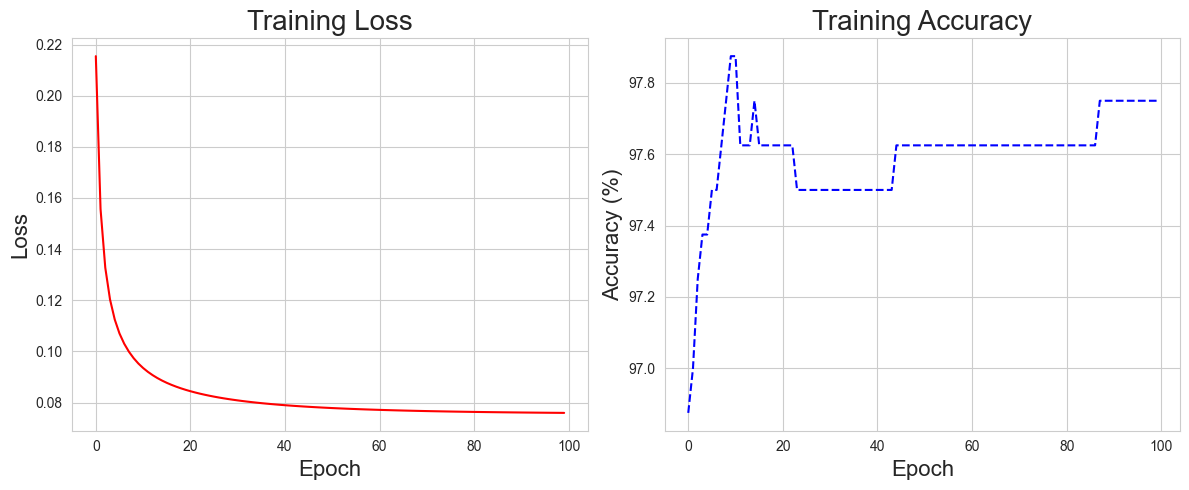

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 5))

ax1.plot(model.loss_history, 'r-')
ax1.set_xlabel('Epoch',fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Training Loss', fontsize=20);

ax2.plot(model.accuracy_history, 'b--')
ax2.set_xlabel('Epoch', fontsize=16)
ax2.set_ylabel('Accuracy (%)', fontsize=16)
ax2.set_title('Training Accuracy', fontsize=20)

fig.tight_layout()

## Predictions and Evaluations
**Check accuracies for the trainig and test data.**

In [17]:
ytr_preds = model.predict(X_train)
print('Final train accuracy: ', model.accuracy(ytr_preds,y_train), '%')

yte_preds = model.predict(X_test)
print('Final test accuracy: ', model.accuracy(yte_preds,y_test), '%')

Final train accuracy:  97.75 %
Final test accuracy:  95.0 %


**Create a classification report for the model.**

In [18]:
from sklearn.metrics import classification_report

In [19]:
print(classification_report(y_test,yte_preds))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        89
           1       0.98      0.93      0.95       111

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



## Exercise

Modify the Python code for ``LogisticClassifier`` so that it can deal with $\ell_2$ regularization. Then test your code. 